In [11]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn, time
import bnlearn as bn
# from pomegranate.bayesian_network import BayesianNetwork

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

In [12]:
# ## dropping some columns to make use of a found causal graph
# adult = adult.drop(['Name', 'DOB', 'SSN', 'Capital Loss', 'Capital Gain', 'fnlwgt', 'Education-Num', 'Zip'], axis=1)
# Alternate Drop scheme
adult = adult.drop(['Name', 'DOB', 'SSN', 'Zip', 'fnlwgt'], axis=1)

pomegranite - python package
  -  Use the baysian networks  - https://pomegranate.readthedocs.io/en/latest/tutorials/B_Model_Tutorial_6_Bayesian_Networks.html
    - https://www.youtube.com/watch?v=TuGDMj43ehw&ab_channel=BertHuang - Quick video on what a baysian network is
  - How to train a Baysian network:
    - https://towardsdatascience.com/how-to-train-a-bayesian-network-bn-using-expert-knowledge-583135d872d7
  - How to create the structure of a baysian network using pomegranate: (includes 3 algorthims dependent on speed)
    - https://notebook.community/jmschrei/pomegranate/tutorials/B_Model_Tutorial_4b_Bayesian_Network_Structure_Learning

Lessons learned from the NIST DP synthetic Data Competition  - https://people.cs.umass.edu/~rmckenna/resources/synthetic.pdf
  - Ryan McKenna
  - Read through this

Notes:
  - Evaluation metrics i can use implement to test my work:
    - Absolute error on 3-way marginals
    

### Attempts to work with pomegranate #####


Ideally we want to get the shape of the graph in order to drop edges until we get a minimal spanning tree.

The shape of the graph does give us a tuple of tuples: ((), (), (), (2), (2,3)) which tells us the parents of each node in the graph, I'mm move forward under the assumption we can find this. I will provide one for the adult data set until I can get this to work.

Issues: BayesianNetwork does not appear to have a method called .from_samples() which most of the walkthroughs on how to do this mention. might need to build this up a little more from scratch by adding distributions as I go.

### DAG from bnlearn

Working a little better than my attempts to use pomegranate.

methodtype: 'hc': hill climber

In [13]:
adult_dag = bn.structure_learning.fit(adult, methodtype='hc', scoretype='bic')

[bnlearn] >Warning: Computing DAG with 14 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


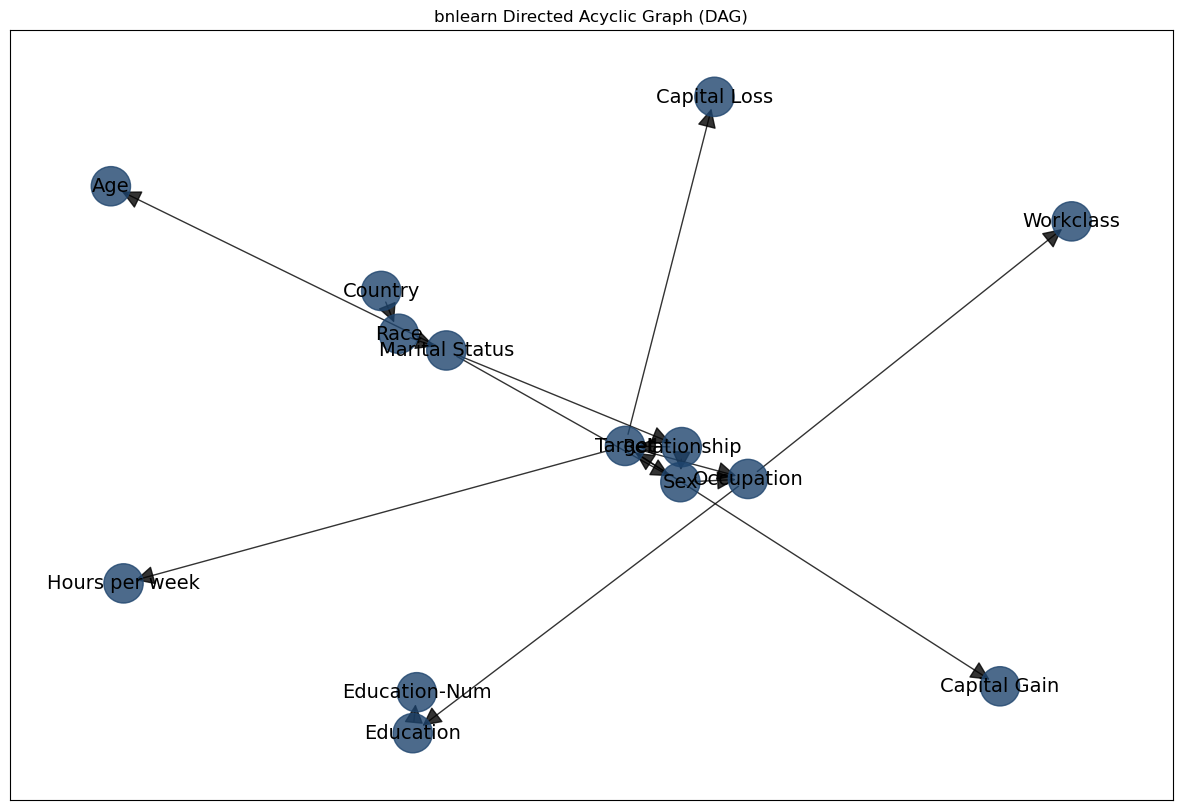

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'Age': array([-0.76878026,  0.73213251]),
  'Workclass': array([0.88331073, 0.62686389]),
  'Education': array([-0.24966282, -0.90632114]),
  'Education-Num': array([-0.2427651 , -0.78368676]),
  'Marital Status': array([-0.19194071,  0.24013244]),
  'Occupation': array([ 0.32672383, -0.14475762]),
  'Relationship': array([ 0.2128621 , -0.04934284]),
  'Race': array([-0.27377912,  0.29018867]),
  'Sex': array([ 0.2105136 , -0.15440138]),
  'Capital Gain': array([ 0.76007207, -0.76589097]),
  'Capital Loss': array([0.26908705, 1.        ]),
  'Hours per week': array([-0.74702643, -0.45761267]),
  'Country': array([-0.30398057,  0.41852089]),
  'Target': array([ 0.11536561, -0.04582501])},
 'G': <networkx.classes.digraph.DiGraph at 0x211a2c3d750>,
 'node_properties': {'Age': {'node_color': '#1f456e', 'node_size': 800},
  'Workclass': {'node_color': '#1f456e', 'node_size': 800},
  'Education'

In [14]:
bn.plot(adult_dag)

### Taking the structure of the Baysian Network to create a minimal spanning tree #####

In [15]:

Going forward because of previous trouble I'm going to assume I know the causal graph Below is a representation of it completed in probably an awful way.

using https://www.researchgate.net/figure/Causal-graph-for-Adult-dataset-the-red-node-represents-the-protected-attribute-the-blue_fig2_310673887 to create the graph and dropping the columns that are not used.

SyntaxError: unterminated string literal (detected at line 1) (1586799546.py, line 1)

In [ ]:
adult.head(1)

In [ ]:
causal_dict = {'Age': (), 
               'Workclass': ('Age', 'Education', 'Country', 'Hours per week'), 
               'Education': ('Race', 'Age', 'Country', 'Sex'),
               'Marital Status': ('Race', 'Age', 'Workclass', 'Hours per week', 'Country', 'Sex'),
               'Occupation': ('Race', 'Age', 'Education', 'Workclass', 'Marital Status', 'Sex'),
               'Relationship': ('Marital Status', 'Education', 'Age', 'Country', 'Sex'),
               'Race': (),
               'Sex': (),
               'Hours per week': ('Race', 'Education', 'Age', 'Country', 'Sex'),
               'Country': (),
               'Target': ('Race', 'Age', 'Education', 'Occupation', 'Workclass', 'Marital Status', 'Hours per week', 'Relationship', 'Country', 'Sex')}

In [ ]:
indices = ['Age', 'Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Hours per week', 'Country', 'Target']

In [ ]:
causal_graph = tuple(tuple(indices.index(x) for x in causal_dict[col]) for col in indices)

In [ ]:
causal_graph

### Building minimal spanning DAG

In [ ]:
## Adjacency matrix
adult_dag['adjmat']

In [ ]:
bn.topological_sort(adult_dag)

In [ ]:
adult_dag['model_edges']

In [ ]:
#### idea for algorithm, greedy
""" Go through the topologically sorted list:
         Find all edges starting with given column and add them to our marginals, checking which column they are directed to
            remove any other edges from possible edges that are directed to the directed to node
"""
def prune_edges(dag):
    # find a topological ordering of the dag nodes
    topo_nodes = bn.topological_sort(dag)
    
    # get the edges of the dag for altering
    all_edges = dag['model_edges']
    
    # This list will contain the nodes we already have accounted for as being "caused" by another node
    # Note: Causation isn't really the right term here as causation is impossible to prove, the DAG we have
    # is just an exampleof something that looks right, but it does also imply that ones 'marital status' => 'Sex'
    # which is not likely to be true
    to_nodes = []
    min_edges = []
    
    for node in topo_nodes:
        for edge in all_edges:
            if edge[0] == node and (edge[1] not in to_nodes):
                # add edge[1] to to_nodes
                to_nodes.append(edge[1])
                # add the edge to min_edges
                min_edges.append(edge)
    
    return min_edges

edges = prune_edges(adult_dag)
edges

In [ ]:
#### With the above edges we can create a marginal for each
#### Unintended consequence: The ordering of the marginals here is exactly what we need to create a row of synthetic data

def dp_two_marginal(df, col1, col2, epsilon):
    
    # create noisy contingency table
    ct = df[[col1, col2]].value_counts()
    noisy_ct = ct.apply(lambda x: laplace_mech(x, 1, epsilon))
    
    non_negative_noisy_ct = np.clip(noisy_ct, 0, None)
    total = np.sum(np.sum(non_negative_noisy_ct))
    
    marginals = non_negative_noisy_ct / total
    
    return marginals.to_frame(name='probability').reset_index()

### From a list of edges, create a dictionary of marginals
def create_marginals(df, edges, epsilon):
    marginal_dict = {}
    
    epsilon_frac = len(edges)
    
    for edge in edges:
        marginal_dict[edge] = dp_two_marginal(df, edge[0], edge[1], epsilon_frac)
    
    return marginal_dict

In [ ]:
epsilon = 1.0
marginals = create_marginals(adult, edges, epsilon)

In [ ]:
#### Now we create a function that will create the data
def gen_samples(n, marginal):
        samples = marginal.sample(n=n,
                                  replace=True,
                                  weights='probability')
        return samples

def gen_col_val(causal_col, causal_val, target_col, marginal):
        
        # create a new marginal based on the given value for the causal_column
        conditional_marginal = marginal[marginal[causal_col] == causal_val]
        total = conditional_marginal['probability'].sum()
        conditional_marginal['probability'] / total
        
        target_val = conditional_marginal.sample(1, replace=True, weights='probability')[target_col].iloc[0]
        
        return target_val
    
### n rows of synthetic data, from a marginal dictionary and a helpful edge list in topological order
def create_synthetic_data(n, marg_dict, edges):
    
    synthetic_data = pd.DataFrame()
    
    # start at the top of the order
    for edge in edges:
        
        # 1. Our dataset is currently empty
        # Create the first 2 columns of data
        if synthetic_data.empty:
            synthetic_data = gen_samples(n, marg_dict[edge]).drop(['probability'], axis=1)
        
        # 2. We are creating a column that branches off an existing column
        # create a conditional marginal using the value in edge[0]
        # generate values for the new column using this data
        elif edge[0] in synthetic_data.columns:
            synthetic_data[edge[1]] = synthetic_data.apply(lambda row: \
                                                                     gen_col_val(edge[0], row[edge[0]], edge[1], marg_dict[edge]), \
                                                                     axis = 1)
        
        # 3. We are creating 2 new columns, one of which is a root, but we have already generated some columns
        # use the two-way marginal to create 2 new columns and merge to the data
        else:
            # we can create the data using gen_samples and just merge it with the rest of the data
            new_columns = gen_samples(n, marg_dict[edge]).drop(['probability'], axis=1)
            # merge new columns with synthetic-data
            synthetic_data = pd.concat([synthetic_data.reset_index(drop=True), new_columns.reset_index(drop=True)], axis=1)
    
    return synthetic_data

In [ ]:
create_synthetic_data(1000, marginals, edges)